In [1]:
import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Tahoma']
import tqdm
### notebook specific configuration ###
from os.path import basename
mpl.style.use('fivethirtyeight')

In [2]:
from Modules.Homer import *

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
sys.path.append('/home/isshamie/software/NGS-Pipeline')

In [4]:
data_folder = '/data/isshamie/CH_tissue_TSS/'

In [5]:
ref_fa = '/data/genome/hamster/picr/picr.fa'
annotation = '/data/genome/hamster/picr/updated_final_sort.gff3'

mrna_peak = '/data/isshamie/TSS_CHO/mRNA.peak'

In [6]:
tissues = ['BloondnegSpleen','BMDM1hKLA1','BMDMwt','Brain','Brain7neg1',
          'FemaleReproductive','Heart','Intestine','Kidney','Liver','Lung',
           'MiscOrgans','Muscle','Pancreas','Skin','Spleen','Total','CHO']

In [7]:
len(tissues)

18

### Load in meta_sampe

In [16]:
meta_samples = pd.read_csv('Results/meta_samples.csv',index_col=0)
meta_samples.head()

,Experiment,Short,Tissue
BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak,GRO,BloondnegSpleen_GRO,BloondnegSpleen
BloondnegSpleen/mSTART/f04_peaks/merge_bg_2.peak,mSTART,BloondnegSpleen_mSTART,BloondnegSpleen
BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak,GRO,BMDM1hKLA1_GRO,BMDM1hKLA1
BMDMwt/GRO/f04_peaks/merge_bg_2.peak,GRO,BMDMwt_GRO,BMDMwt
Brain/GRO/f04_peaks/merge_bg_2.peak,GRO,Brain_GRO,Brain


## Create Peaks by Sample matrix

#### Load in merged peak file 

In [9]:
peaks_merged = pd.read_csv("Results/merged_samples/all_peaks_merged.tsv",sep='\t',index_col=0)


## Drop duplicates
dups = peaks_merged[peaks_merged.index.duplicated(keep=False)]
print 'Number of duplicate indices (having same index name, happens bc both +/- strand on exact same bp): ', len(dups)/2
peaks_merged = peaks_merged[~peaks_merged.index.isin(dups.index)]

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,10,11,12,13,15,16,18,19,20,21,22,23,24,25,26,28,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of duplicate indices (having same index name, happens bc both +/- strand on exact same bp):  24


In [10]:
peak_tissue_matrix = pd.DataFrame(np.zeros([peaks_merged.shape[0],len(peaks_merged.columns.values[7:])],dtype='int64'),
             columns=peaks_merged.columns.values[7:])
peak_tissue_matrix = peak_tissue_matrix[~peak_tissue_matrix.index.duplicated(False)]
peak_tissue_matrix.set_index(peaks_merged.index.values,inplace=True)
for col in peak_tissue_matrix.columns.values:
    print col
    
    try:
        curr_peaks = pd.read_csv(data_folder + col, sep='\t',index_col=0)
    except:
        print 'File couldnt be loaded!'
        continue
    
    # Load in the column file and get the peak values
    filt = peaks_merged.loc[~peaks_merged.loc[:,col].isnull()] ## Get rows where the column had a peak
    curr_AI = filt.index.values
    curr_keys = np.array(filt[col])
    #Filter curr_peaks to only with keys
    curr_peaks = curr_peaks.loc[curr_keys]
    #Save duplicates to deal with later
    curr_dups = curr_peaks[curr_peaks.loc[curr_keys].index.duplicated(keep=False)]
    #Drop the duplicates and assign the non-duplicate values
    curr_peaks = curr_peaks.drop(curr_dups.index)
    print('curr_dups',len(curr_dups))
    vals = np.array(curr_peaks.loc[curr_keys,'Stat'])
    vals = np.nan_to_num(vals) #Turn Stat into 0
    peak_tissue_matrix.loc[curr_AI,col] = vals
    #peak_tissue_matrix.loc[curr_AI,col] = (curr_peaks.loc[curr_keys,'Stat'])
    
# In case any peaks have No tissues with the expression, which shouldn't really happen
peak_tissue_matrix = peak_tissue_matrix.loc[:,np.sum(peak_tissue_matrix > 0)!=0]
peak_tissue_matrix = peak_tissue_matrix.loc[np.sum(peak_tissue_matrix > 0,axis=1)!=0,:]

BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak
('curr_dups', 2)
BloondnegSpleen/mSTART/f04_peaks/merge_bg_2.peak
File couldnt be loaded!
BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak
('curr_dups', 6)
BMDMwt/GRO/f04_peaks/merge_bg_2.peak
('curr_dups', 2)
Brain/GRO/f04_peaks/merge_bg_2.peak
('curr_dups', 2)
Brain/mSTART/f04_peaks/merge_bg_2.peak
('curr_dups', 0)
Brain7neg1/mSTART/f04_peaks/merge_bg_2.peak
File couldnt be loaded!
FemaleReproductive/mSTART/f04_peaks/merge_bg_2.peak
('curr_dups', 0)
Heart/mSTART/f04_peaks/merge_bg_2.peak
('curr_dups', 0)
Intestine/mSTART/f04_peaks/merge_bg_2.peak
File couldnt be loaded!
Kidney/GRO/f04_peaks/merge_bg_2.peak
('curr_dups', 0)
Kidney/mSTART/f04_peaks/merge_bg_2.peak
('curr_dups', 0)
Liver/GRO/f04_peaks/merge_bg_2.peak
('curr_dups', 2)
Liver/mSTART/f04_peaks/merge_bg_2.peak
('curr_dups', 0)
Lung/GRO/f04_peaks/merge_bg_2.peak
('curr_dups', 4)
Lung/mSTART/f04_peaks/merge_bg_2.peak
('curr_dups', 0)
MiscOrgans/mSTART/f04_peaks/merge_bg_2.peak
('curr_dups'

In [11]:
## Save peaks_merged_tissue_matrix
peak_tissue_matrix.to_csv('Results/merged_samples/peaks_tissues.csv')

# Clustering
Using all peaks, promoter peaks, binarized and unbinarized, and with and without mSTART (which had less)
Also will cluster promoter peaks with all samples (replicates treated separately) to see if clustering is working as expected

## Cluster promoter

In [12]:
### First filter peaks to only promoter
anno_peaks = pd.read_csv('Results/merged_samples/all_peaks_merged_anno.tsv',sep='\t',index_col=0)

anno_peaks = anno_peaks.fillna('')
promoter_peaks = anno_peaks[anno_peaks['Annotation'].str.contains('promoter')].index

promoter_tissue_matrix = peak_tissue_matrix[peak_tissue_matrix.index.isin(promoter_peaks)]

In [13]:
print 'Number of promoter peaks: ', len(promoter_tissue_matrix)

Number of promoter peaks:  104295


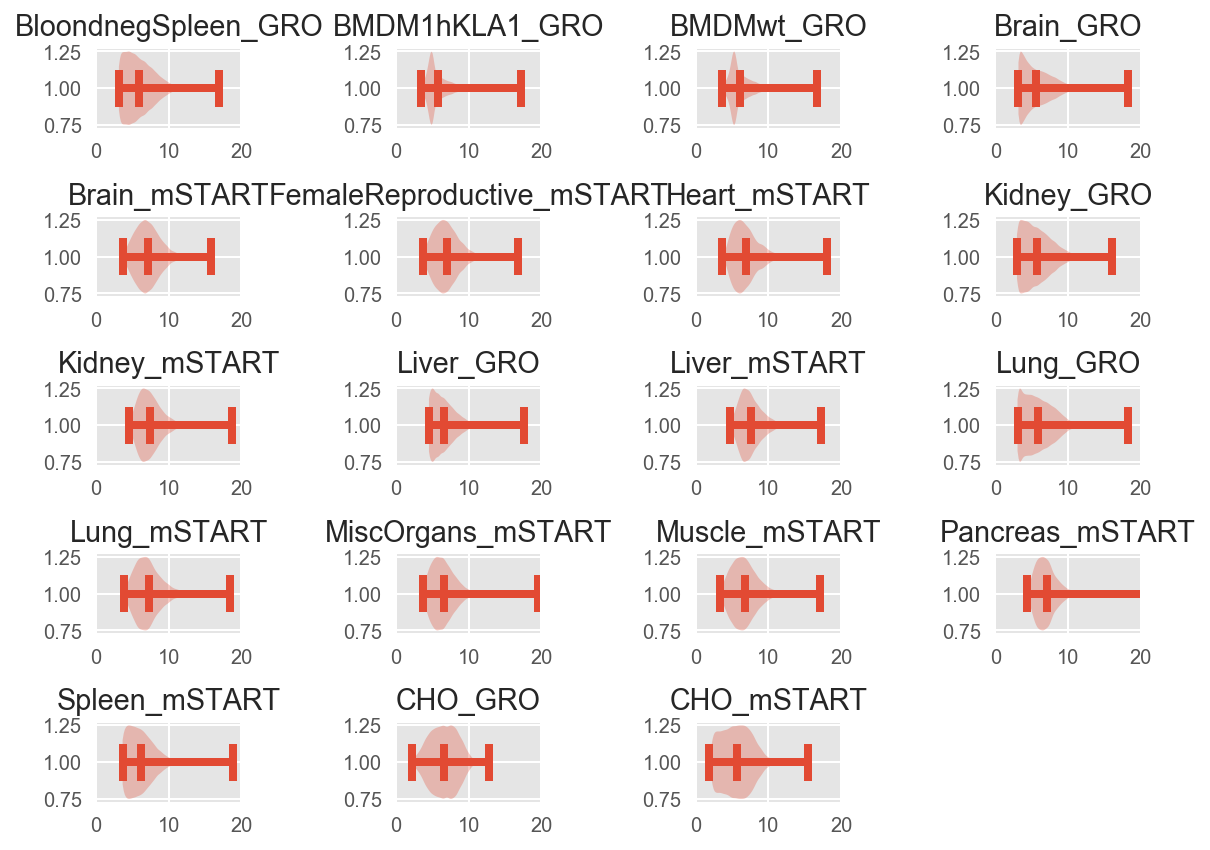

In [22]:
f = plt.figure()
promoter_tissue_log2 = np.log2(promoter_tissue_matrix + 1)

N = len(promoter_tissue_log2.columns.values)
cols = 4
rows = np.ceil(1.0*N / 4)
n = 1
for i in promoter_tissue_log2.columns.values:
    ax = f.add_subplot(rows,cols,n)
    curr = promoter_tissue_log2.loc[:,i]
    curr = curr[curr>0]
    plt.violinplot(curr,vert=False,showmeans=True)
    curr_title = i.split('/')[0] + '_' + i.split('/')[1]
    ax.set_title(curr_title)
    ax.set_xlim([0,20])
    n += 1

plt.tight_layout()
plt.savefig('Results/Figures/violin_score_peaks.png')

### Binary

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


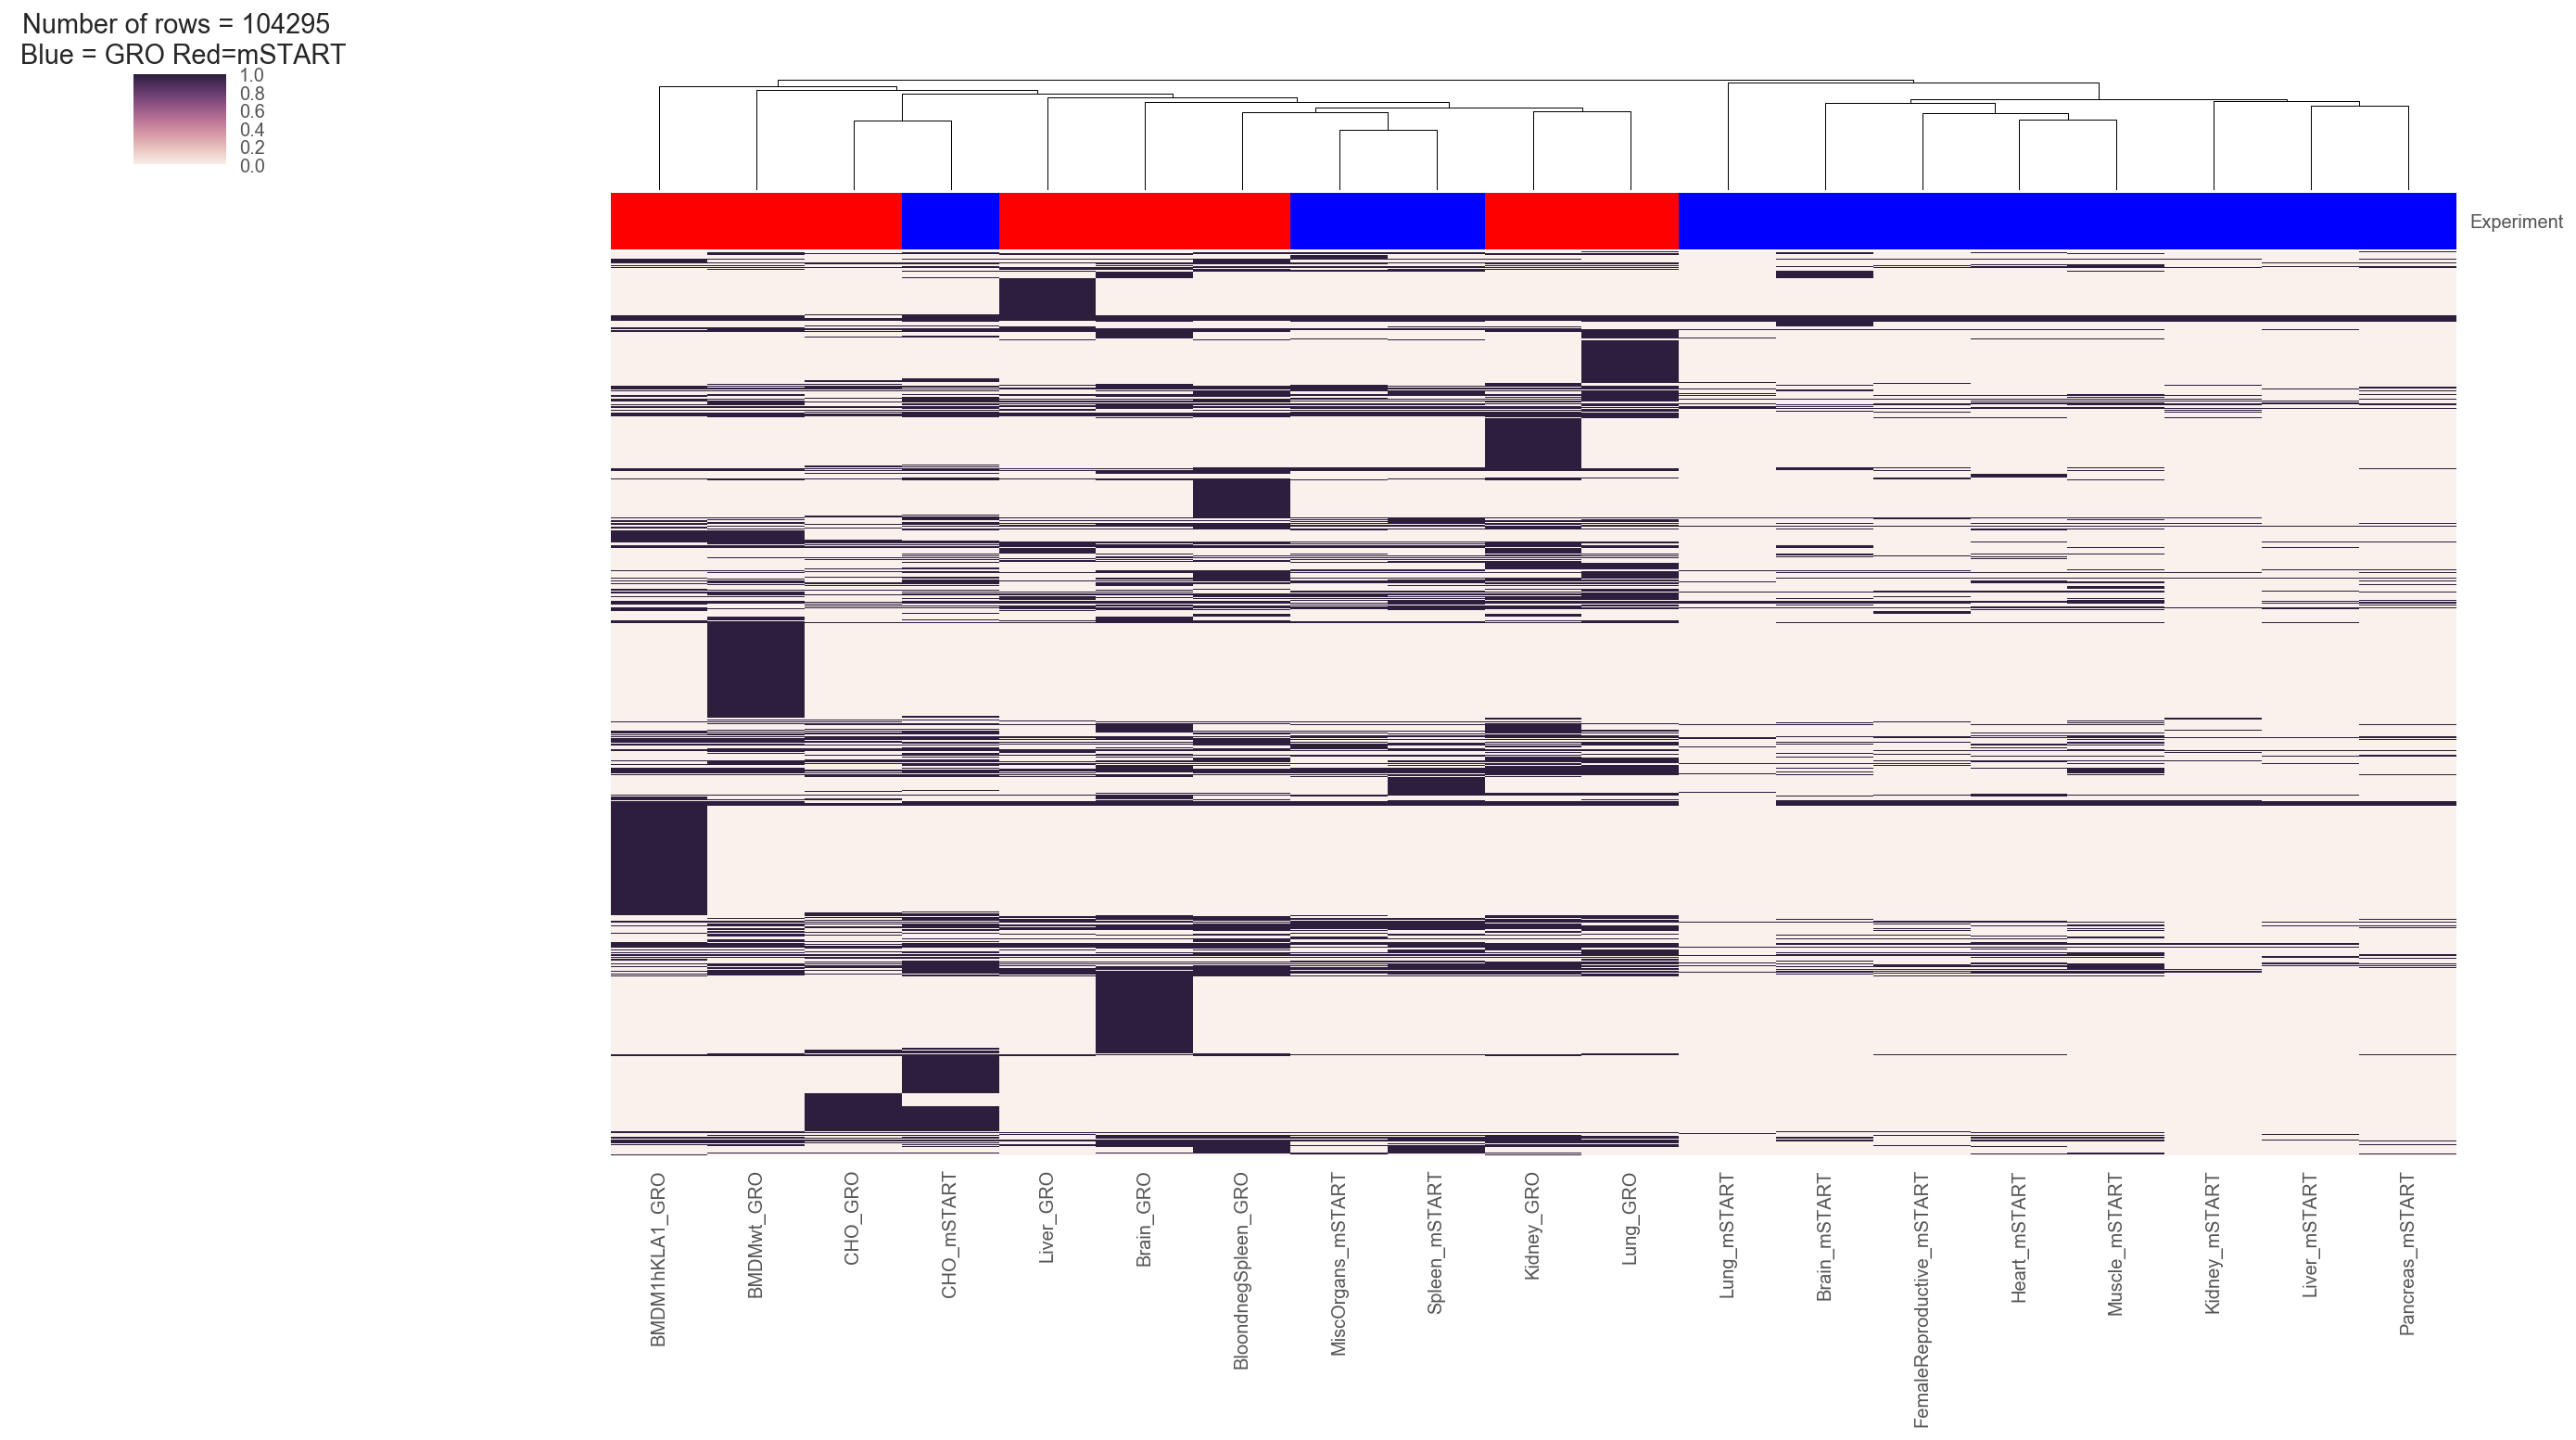

In [17]:
short_prom = promoter_tissue_matrix > 0

lut = dict(zip(meta_samples.loc[short_prom.columns.values,'Experiment'].unique(), "rbg"))
col_colors = meta_samples.loc[short_prom.columns.values,'Experiment'].map(lut)

g = sns.clustermap(short_prom,col_cluster=True,figsize=(20,10),metric='jaccard',row_cluster=False
                   ,yticklabels=False,col_colors=col_colors,xticklabels=meta_samples.loc[short_prom.columns.values,'Short'])
title = 'Number of rows = %d \n Blue = GRO Red=mSTART' % len(short_prom)
plt.title(title)
g.savefig('Results/Figures/binary_jaccard_promoter_peak_cluster.png',bbox_inches='tight')

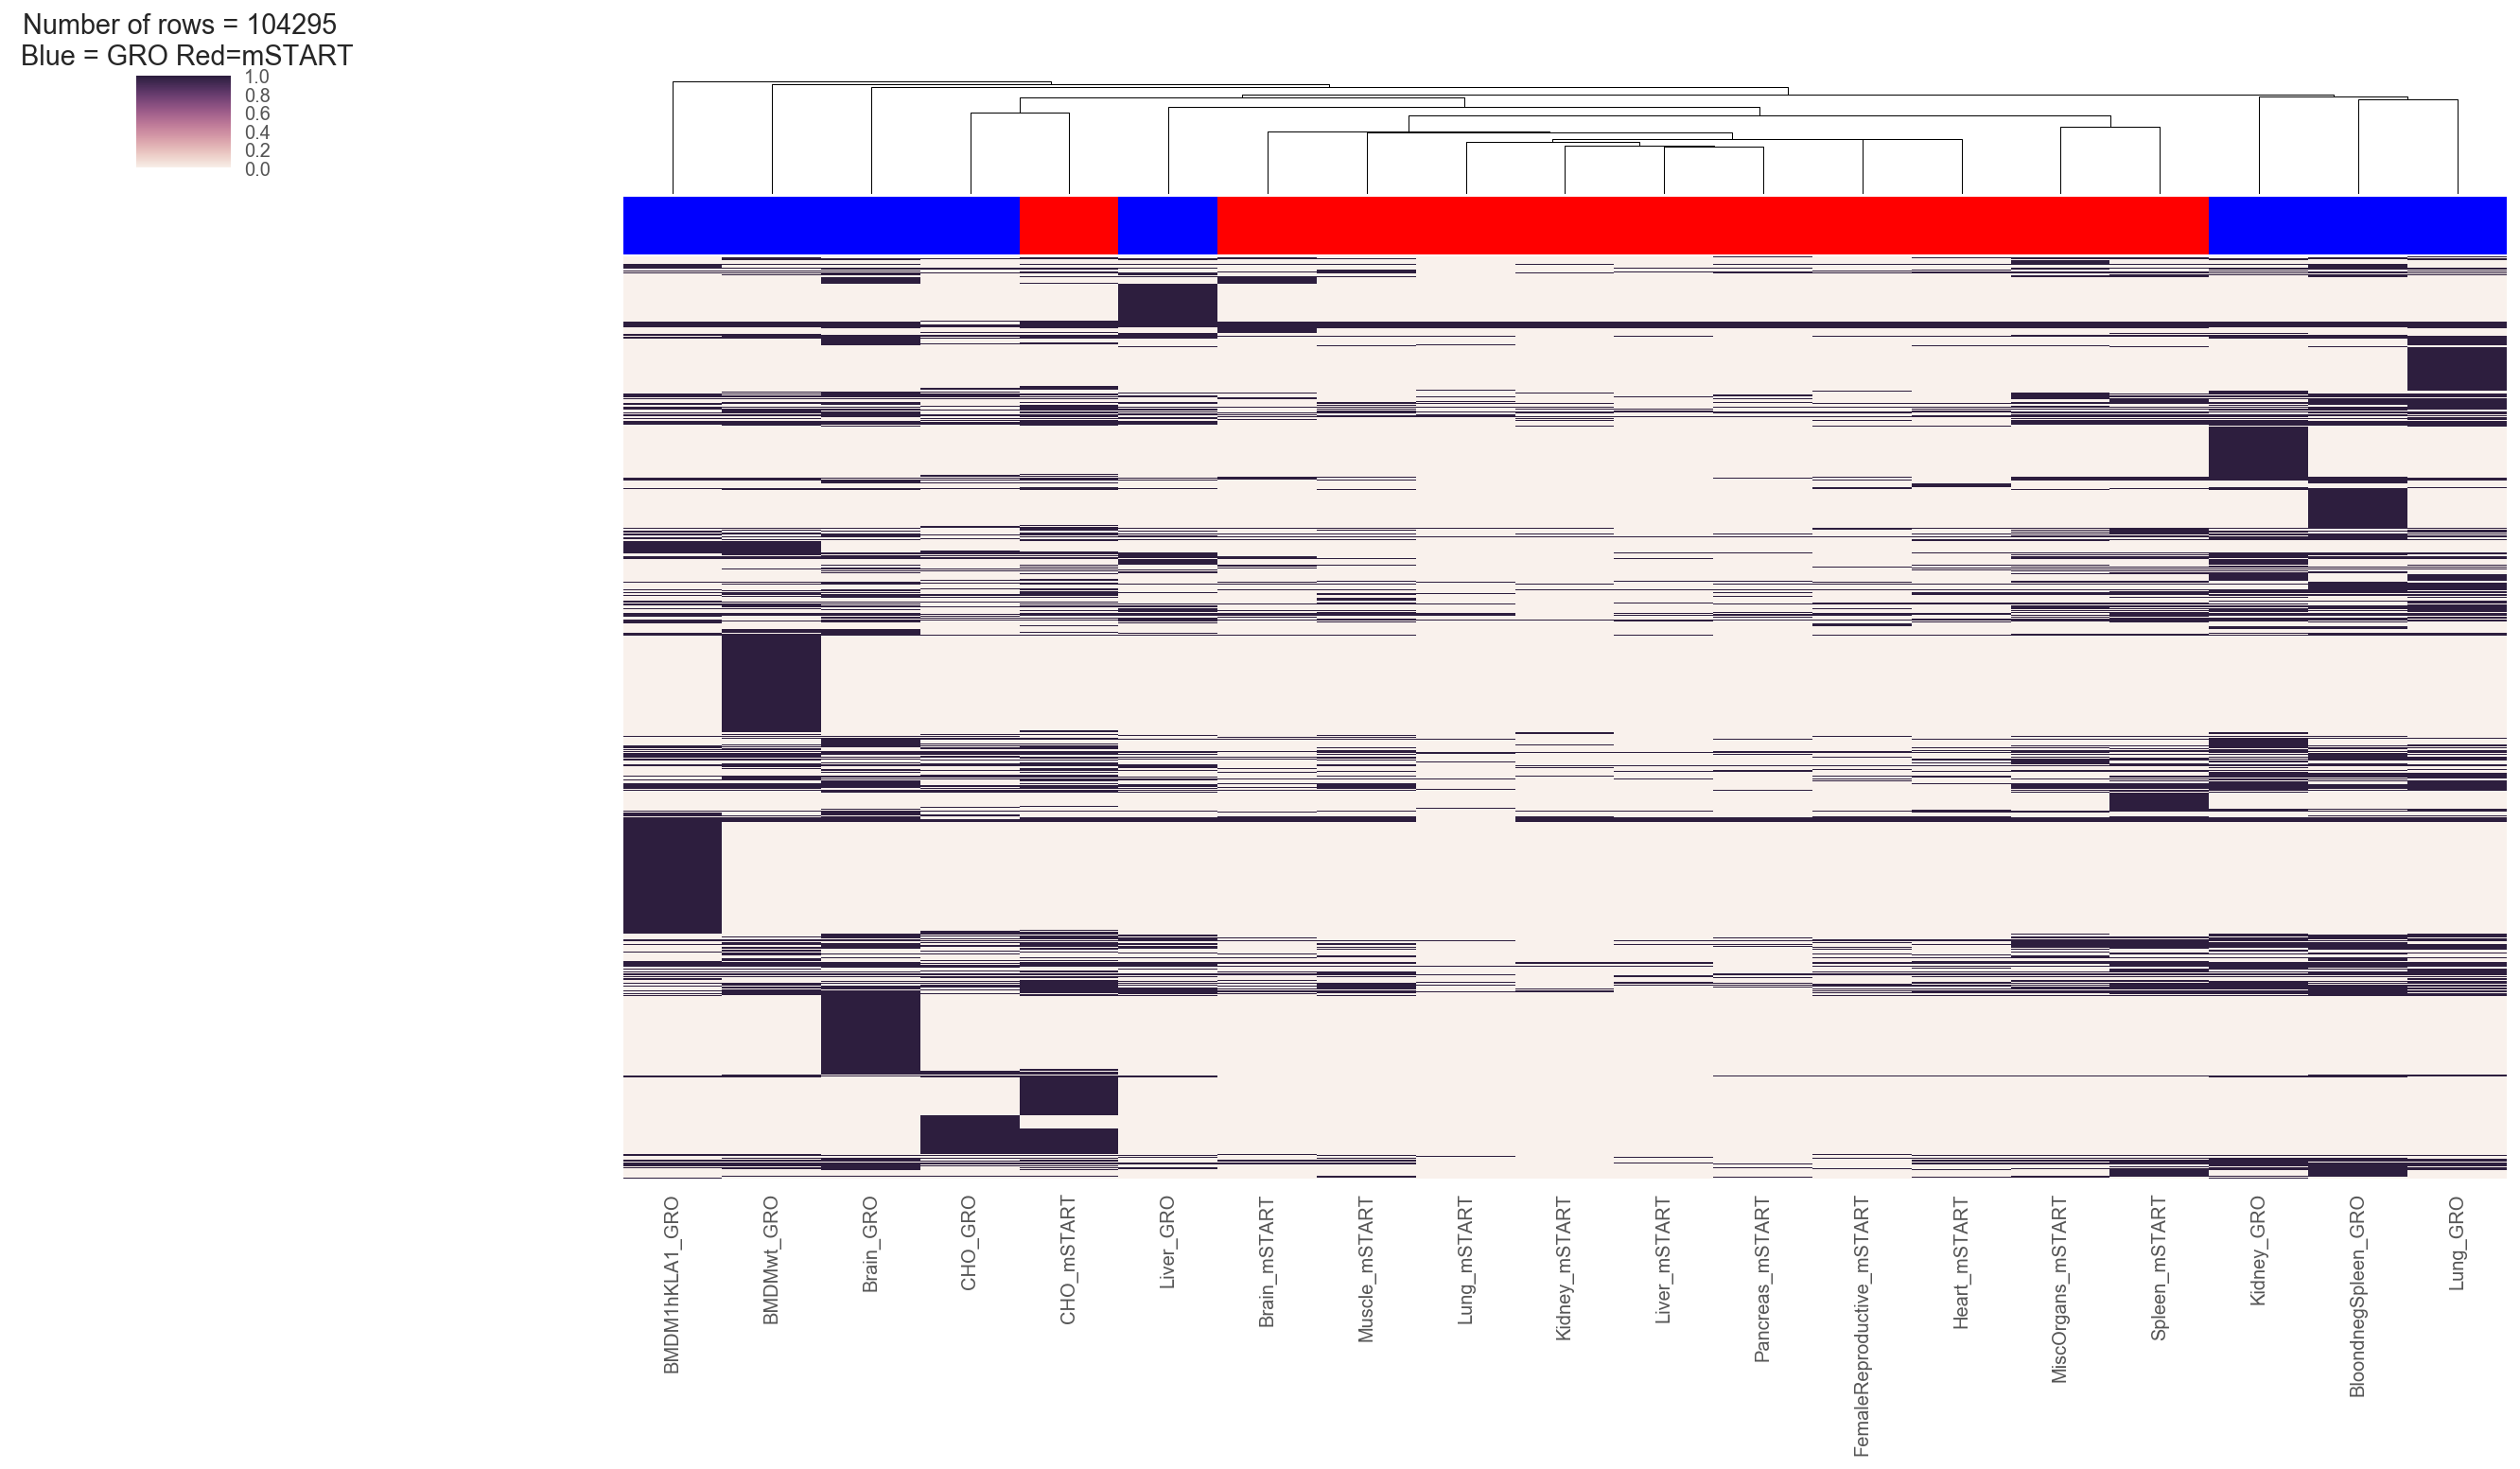

In [19]:
promoter_tissue_matrix = peak_tissue_matrix[peak_tissue_matrix.index.isin(promoter_peaks)]

promoter_tissue_matrix = promoter_tissue_matrix[~(np.sum(promoter_tissue_matrix == 0,axis=1) == 19)]
short_prom = promoter_tissue_matrix > 0


#short_prom = promoter_tissue_matrix
col_colors = ["b" if i == 'GRO' else "r"  for i in np.array(meta_samples.loc[short_prom.columns.values,'Experiment'])]

g = sns.clustermap(short_prom,col_cluster=True,figsize=(20,10),row_cluster=False,
                   yticklabels=False,col_colors=col_colors,xticklabels=meta_samples.loc[short_prom.columns.values,'Short'])
    #Color columns by experimental setup

title = 'Number of rows = %d \n Blue = GRO Red=mSTART' % len(short_prom)
plt.title(title)

g.savefig('Results/Figures/binary_promoter_peak_cluster.png',bbox_inches='tight')

### log2 Real-Valued

In [ ]:
#short_prom = promoter_tissue_matrix.iloc[np.random.choice(promoter_tissue_matrix.shape[0],1000,replace=False)]
col_colors = ["b" if i == 'GRO' else "r"  for i in np.array(meta_samples.loc[short_prom.columns.values,'Experiment'])]
f = plt.figure(dpi=300)
g = sns.clustermap(np.log2(short_prom+1),col_cluster=True,figsize=(20,10)
                   ,yticklabels=False,col_colors=col_colors,xticklabels=meta_samples.loc[short_prom.columns.values,'Short'])
g.savefig('Results/Figures/promoter_peak_cluster_log2.png',bbox_inches='tight')

## Determine overlap between mSTART and GRO peaks

In [75]:
N = 0
is_in_gro = []
not_in_gro = []
total_gro = []

names = []
for tissue,i in meta_samples.groupby('Tissue'):
    if len(i) > 1 and not tissue == 'BloondnegSpleen':
        names.append(tissue)
        N += 1
        print 'here'
        for ind,val in i.iterrows():
            print ind
            if val['Experiment'] == 'mSTART':
                mstart = promoter_tissue_matrix[promoter_tissue_matrix[ind] > 0].index
            else:
                gro = promoter_tissue_matrix[promoter_tissue_matrix[ind] > 0].index
                total_gro.append(len(gro))
        
        is_in_gro.append(np.sum(mstart.isin(gro)))
        not_in_gro.append(np.sum(~mstart.isin(gro)))

here
Brain/GRO/f04_peaks/merge_bg_2.peak
Brain/mSTART/f04_peaks/merge_bg_2.peak
here
CHO/GRO/f04_peaks/merge_bg_2.peak
CHO/mSTART/f04_peaks/merge_bg_2.peak
here
Kidney/GRO/f04_peaks/merge_bg_2.peak
Kidney/mSTART/f04_peaks/merge_bg_2.peak
here
Liver/GRO/f04_peaks/merge_bg_2.peak
Liver/mSTART/f04_peaks/merge_bg_2.peak
here
Lung/GRO/f04_peaks/merge_bg_2.peak
Lung/mSTART/f04_peaks/merge_bg_2.peak


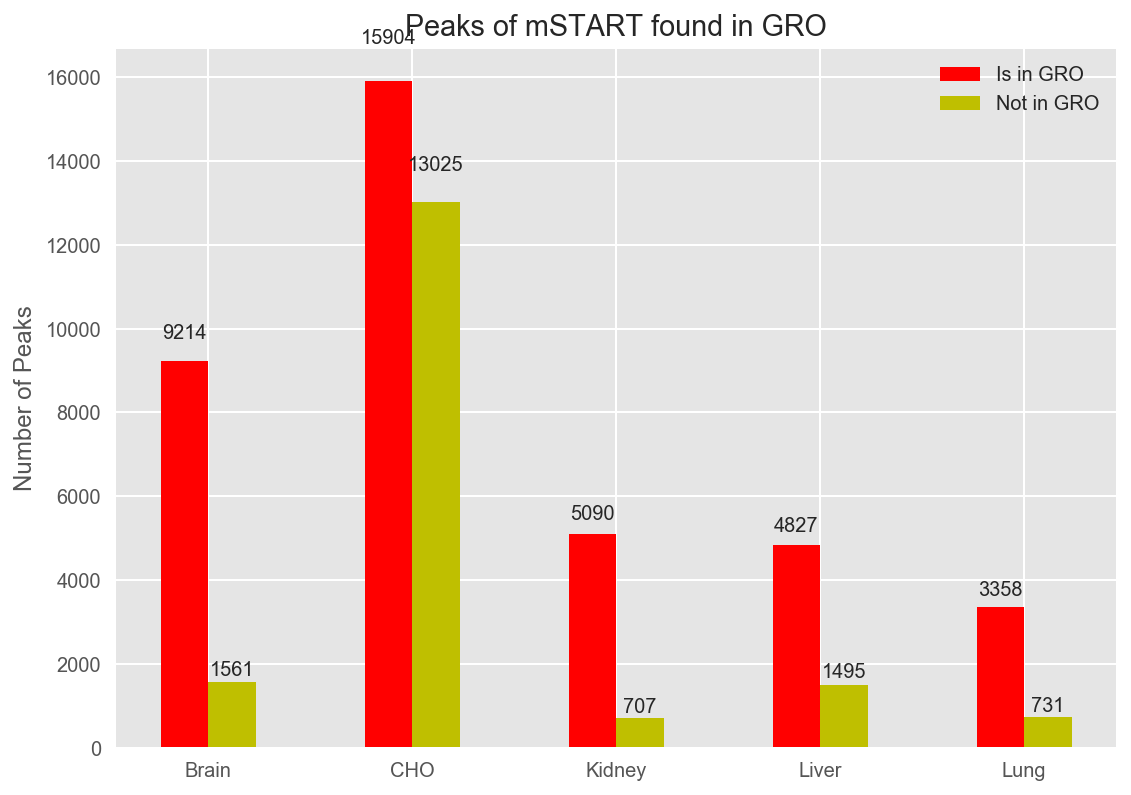

In [91]:
ind = 1.5*np.arange(N)  # the x locations for the groups
width = 0.35      # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, is_in_gro, width, color='r')

rects2 = ax.bar(ind + width, not_in_gro, width, color='y')


# add some text for labels, title and axes ticks
ax.set_ylabel('Number of Peaks')
ax.set_title('Peaks of mSTART found in GRO')
ax.set_xticks(ind + width / 2)

tuple([i for i in names])
ax.set_xticklabels(tuple([i for i in names]))


ax.legend((rects1[0], rects2[0]), ('Is in GRO', 'Not in GRO'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

#plt.show()

plt.savefig('Results/Figures/GRO_mSTART_comparison.png',bbox_inches='tight')

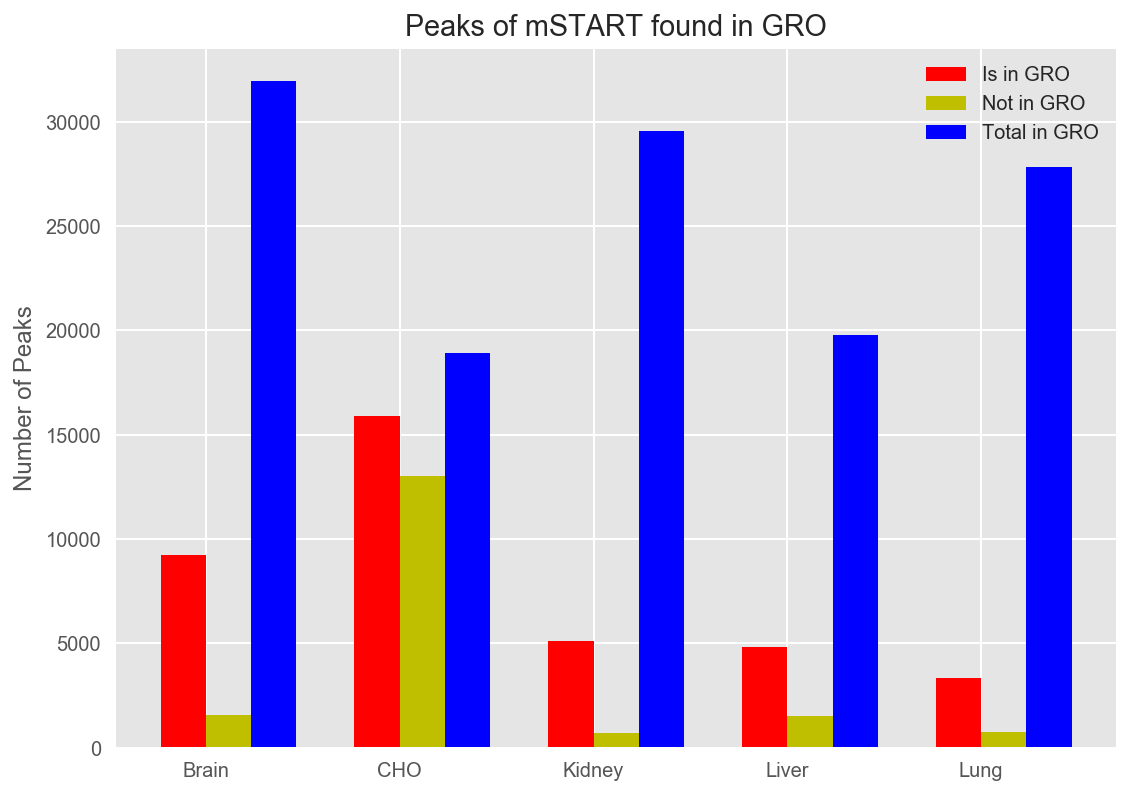

In [90]:
ind = 1.5*np.arange(N)  # the x locations for the groups
width = 0.35      # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, is_in_gro, width, color='r')


rects2 = ax.bar(ind + width, not_in_gro, width, color='y')

rects3 = ax.bar(ind + 2*width, total_gro, width, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of Peaks')
ax.set_title('Peaks of mSTART found in GRO')
ax.set_xticks(ind + width / 2)

tuple([i for i in names])
ax.set_xticklabels(tuple([i for i in names]))


ax.legend((rects1[0], rects2[0],rects3[0]), ('Is in GRO', 'Not in GRO','Total in GRO'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

plt.savefig('Results/Figures/GRO_mSTART_comparison_full.png',bbox_inches='tight')

## Venn Diagram of GRO/mSTART overlap

In [119]:
from matplotlib_venn import venn2

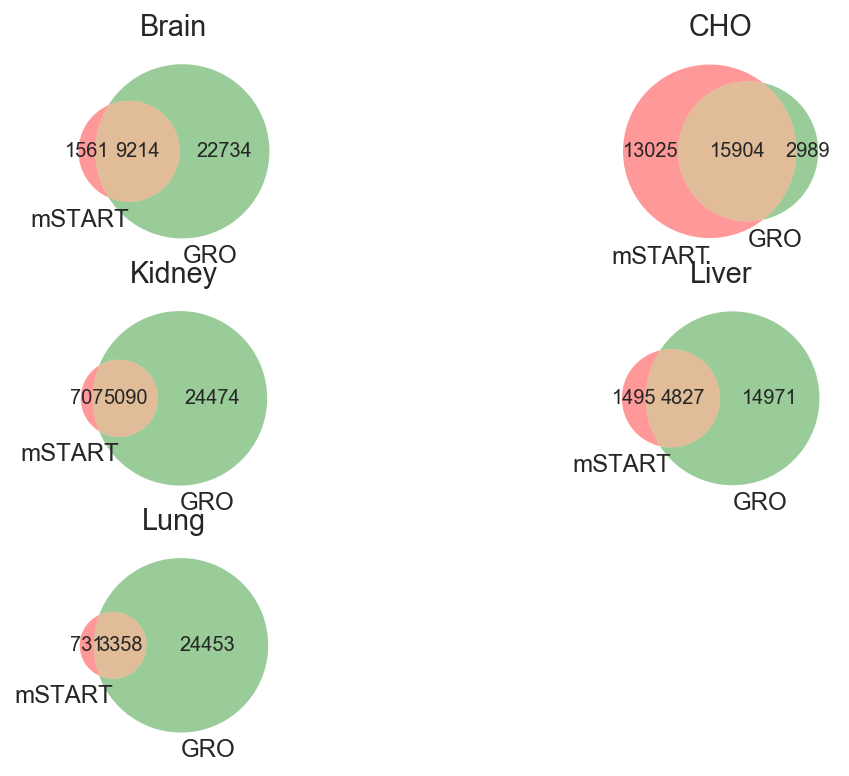

In [130]:
count = 1
f = plt.figure()

for i in range(len(is_in_gro)):
    ax = f.add_subplot(len(is_in_gro)/2 + 1 ,2,count)
    venn2((not_in_gro[i],total_gro[i]-is_in_gro[i],is_in_gro[i]),set_labels=('mSTART','GRO'))
    ax.set_title(names[i])
    count += 1
plt.savefig('Results/Figures/GRO_mSTART_comparison_venn.png',bbox_inches='tight')